# Anticipez les besoins en consommation de bâtiments.

## Notebook de prédiction des émissions de CO2.

J'importe les librairies nécessaires.

In [1]:
import pandas as pd
import numpy as np
import shap
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


In [2]:
data = pd.read_csv("data.csv")
data.head()

,Unnamed: 0,Age,NumberofFloors,NumberofBuildings,PropertyGFABuilding(s),PropertyGFATotal,LargestPropertyUseTypeGFA,ProportionBuildingSurface,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,PrimaryPropertyType,TotalGHGEmissions,SiteEnergyUseWN(kBtu),ENERGYSTARScore
0,0,95,12,1.0,88434,88434,88434.0,100.000000,No,No,Hotel,7.965669,22.830146,60.0
1,1,26,11,1.0,88502,103566,83880.0,85.454686,Yes,Yes,Hotel,8.208771,23.046682,61.0
2,2,53,41,1.0,759392,956110,756493.0,79.425171,No,No,Hotel,11.028790,26.139795,43.0
3,3,96,10,1.0,61320,61320,61320.0,100.000000,No,No,Hotel,8.162039,22.727917,56.0
4,4,42,18,1.0,113580,175580,123445.0,64.688461,Yes,Yes,Hotel,8.980168,23.805038,75.0


Je redéfinis mon DataFrame qui sera utilisé dans ce notebook.

In [3]:
data_ghg = data.loc[:, ["Age", "NumberofFloors",  "NumberofBuildings", "PropertyGFABuilding(s)", "PropertyGFATotal", "LargestPropertyUseTypeGFA", "ProportionBuildingSurface", "SecondLargestPropertyUseType", "ThirdLargestPropertyUseType", "PrimaryPropertyType",  "TotalGHGEmissions"]]

Je vais créer la matrice de données (composée des variables intéressantes) et le vecteur d'étiquette (composé de la variable concernant les émissions de CO2).

In [4]:
X = data_ghg[data_ghg.columns[:-1]].values
y = data_ghg["TotalGHGEmissions"].values

Je crée un jeu d'entraînement et un jeu de test (30% des données).

In [5]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.3)

### 1) Choix du modèle.

Je créer un transformer pour encoder mes variables catégorielles.

In [6]:
transformer = ColumnTransformer(transformers = [("ohe", OneHotEncoder(handle_unknown = "ignore", sparse = False), [7, 8, 9])],
                                remainder = "passthrough")

Je créer une pipeline pour aggréger les étapes de processing pour tester les modèles de base.

In [7]:
steps = [("t", transformer), ("std", StandardScaler(with_mean=False)), ("model", LinearRegression())]
pipe = Pipeline(steps)
pipe.fit(X_train, y_train)

Pipeline(steps=[('t',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  [7, 8, 9])])),
                ('std', StandardScaler(with_mean=False)),
                ('model', LinearRegression())])

In [8]:
param_grid = {"model" : [LinearRegression(), KNeighborsRegressor(), SVR(), DecisionTreeRegressor(), RandomForestRegressor(),GradientBoostingRegressor(), xgb.XGBRegressor()]}
grid = GridSearchCV(pipe, param_grid, cv = 5, return_train_score=True)
grid.fit(X_test, y_test)
print ("Best: ", grid.best_score_, "using ", grid.best_params_)

Best:  0.5171272184573563 using  {'model': GradientBoostingRegressor()}


J'analyse ensuite les performances des autres modèles à titre comparatif.

In [9]:
pd.DataFrame(grid.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.005134,0.001078,0.002004,0.000316,LinearRegression(),{'model': LinearRegression()},0.414541,0.495215,0.406444,0.346468,...,0.392355,0.066440,5,0.528125,0.510400,0.531814,0.546800,0.528371,0.529102,0.011592
1,0.002565,0.000058,0.001819,0.000245,KNeighborsRegressor(),{'model': KNeighborsRegressor()},0.183557,0.462974,0.237530,0.261415,...,0.316560,0.112247,6,0.567867,0.547450,0.606178,0.602691,0.567462,0.578330,0.022584
2,0.009209,0.000100,0.002864,0.000126,SVR(),{'model': SVR()},0.477648,0.450051,0.477099,0.344876,...,0.454084,0.059112,3,0.536460,0.533531,0.534372,0.557517,0.512753,0.534927,0.014189
3,0.004816,0.000638,0.001326,0.000372,DecisionTreeRegressor(),{'model': DecisionTreeRegressor()},-0.156895,-0.027424,-0.176707,0.113004,...,0.002301,0.165343,7,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
4,0.220988,0.034788,0.008529,0.001382,RandomForestRegressor(),{'model': RandomForestRegressor()},0.450834,0.527847,0.442089,0.335874,...,0.481309,0.104123,2,0.929563,0.928752,0.927562,0.929898,0.923045,0.927764,0.002493
5,0.057647,0.000936,0.001239,0.000128,GradientBoostingRegressor(),{'model': GradientBoostingRegressor()},0.489988,0.598220,0.472251,0.396866,...,0.517127,0.085031,1,0.807247,0.806920,0.799058,0.820587,0.773998,0.801562,0.015421
6,0.059377,0.000627,0.003067,0.000039,"XGBRegressor(base_score=None, booster=None, co...","{'model': XGBRegressor(base_score=None, booste...",0.339066,0.488865,0.348857,0.417111,...,0.432976,0.087540,4,0.999041,0.999210,0.999350,0.999263,0.999260,0.999225,0.000102


### 2) Optimisation du modèle.

Le modèle qui correspond le mieux est celui de la régression XGBoost.

Je vais donc appliquer ce modèle à mon jeu de données et chercher les meilleurs hyperparamètres.

In [10]:
steps = [("t", transformer), ("gbr", GradientBoostingRegressor())]
pipe = Pipeline(steps)

J'utilise un RandomizedSearchCV pour avoir une idée des valeurs qui peuvent être prises par les hyperparamètres.

In [11]:
parameters = {'gbr__learning_rate': sp_randFloat(),
                  'gbr__subsample'    : sp_randFloat(),
                  'gbr__n_estimators' : sp_randInt(100, 1000),
                  'gbr__max_depth'    : sp_randInt(4, 10)
                 }

In [12]:
random = RandomizedSearchCV(estimator=pipe, param_distributions = parameters,
                               cv = 2, n_iter = 10, n_jobs=-1)
random.fit(X_train, y_train)
print ("Best: ", random.best_score_, "using ", random.best_params_)

Best:  0.45454680539085274 using  {'gbr__learning_rate': 0.24192404957801839, 'gbr__max_depth': 7, 'gbr__n_estimators': 313, 'gbr__subsample': 0.9339513116976674}


Je cherche les meilleurs hyperparamètres pour mon modèle.

In [13]:
param_grid = {"gbr__n_estimators" : [500, 1000],
              "gbr__learning_rate" : [0.01, 0.1, 1.0],
              "gbr__subsample" : [0.5, 1.0],
              "gbr__max_depth" : [3, 5, 7, 9]
                }

In [14]:
grid = GridSearchCV(pipe, param_grid, n_jobs = -1, cv = 5)
grid.fit(X_train, y_train)
print ("Best: ", grid.best_score_, "using ", grid.best_params_)

Best:  0.5254849809591302 using  {'gbr__learning_rate': 0.01, 'gbr__max_depth': 3, 'gbr__n_estimators': 1000, 'gbr__subsample': 0.5}


J'analyse les performance sur le jeu de test.

In [15]:
pipe.set_params(**grid.best_params_)
pipe.fit(X_train, y_train)
score = pipe.score(X_test, y_test)
print("Performance on the test set: ", score)

Performance on the test set:  0.5508383932568035


### 3) Energy Star Score.

Je vais inclure l'EnergyStarScore dans mon DataFrame afin de voir si il a un impact sur la modélisation.

In [16]:
data_ess = data.loc[:, ["Age", "NumberofFloors",  "NumberofBuildings", "PropertyGFABuilding(s)", "PropertyGFATotal", "LargestPropertyUseTypeGFA", "ProportionBuildingSurface", "SecondLargestPropertyUseType", "ThirdLargestPropertyUseType", "PrimaryPropertyType", "ENERGYSTARScore", "TotalGHGEmissions"]]

In [17]:
X = data_ess[data_ess.columns[:-1]].values
y = data_ess["TotalGHGEmissions"].values
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.3)

In [18]:
steps = [("t", transformer), ("gbr", GradientBoostingRegressor())]
pipe = Pipeline(steps)
pipe.fit(X_train, y_train)

Pipeline(steps=[('t',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  [7, 8, 9])])),
                ('gbr', GradientBoostingRegressor())])

J'utilise le même modèle avec les mêmes paramètres.

In [19]:
pipe.set_params(**grid.best_params_)
pipe.fit(X_train, y_train)
score = pipe.score(X_test, y_test)
print("Performance on testing set: ", score)

Performance on testing set:  0.5682703365364733


### 4) Feature importance.

J'analyse l'importance des features.

In [20]:
coefficients = pipe.steps[1][1].feature_importances_

In [21]:
cat = ["Age", "NumberofFloors", "NumberofBuildings", "PropertyGFABuilding(s)", "PropertyGFATotal", "LargestPropertyUseTypeGFA", "ProportionBuildingSurface", "SecondLargestPropertyUseType", "ThirdLargestPropertyUseType", "PrimaryPropertyType", "ENERGYSTARScore"]

In [22]:
features = pipe["t"].get_feature_names_out(cat)

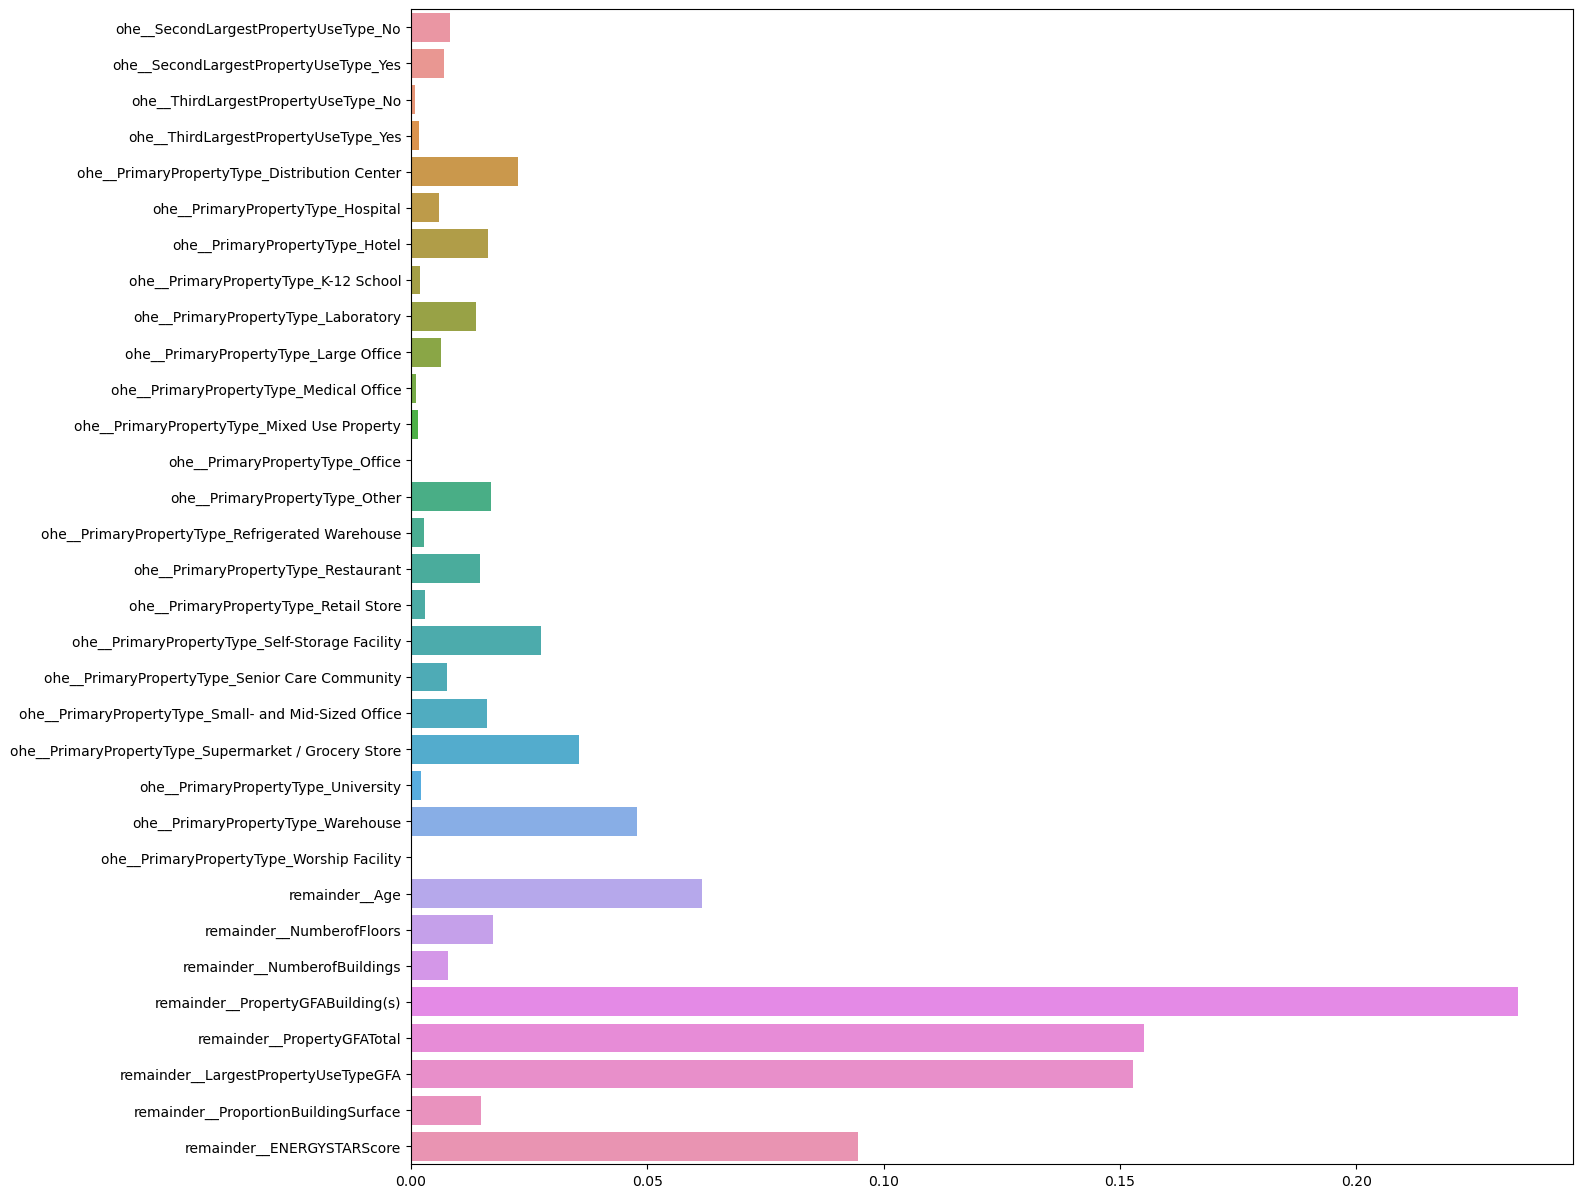

In [23]:
plt.figure(figsize=(15, 15))
sns.barplot( y = features, x = coefficients)
plt.show()

J'analyse l'importance des feature avec shap.

In [24]:
model = pipe.steps[1][1]
model

GradientBoostingRegressor(learning_rate=0.01, n_estimators=1000, subsample=0.5)

In [25]:
features = pipe["t"].transform(X)

In [26]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(features)

In [27]:
feature_names = pipe["t"].get_feature_names_out(cat)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


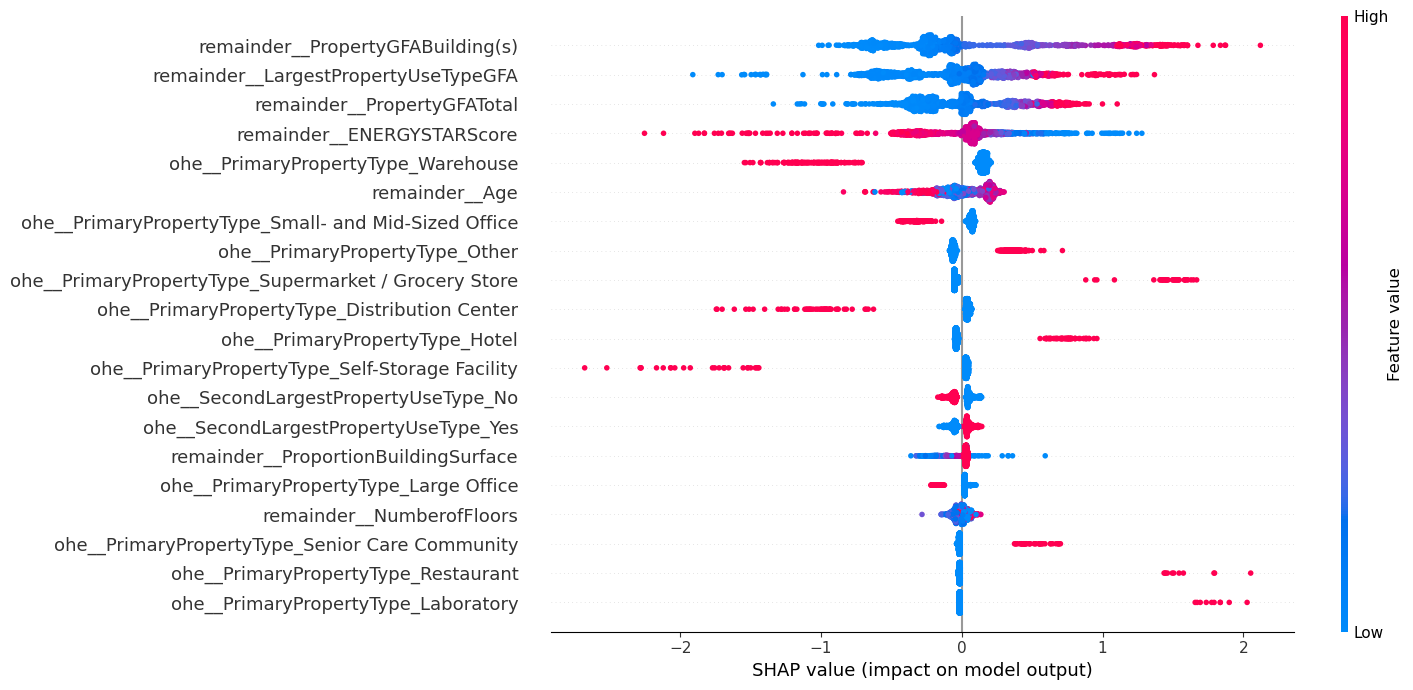

In [28]:
shap.summary_plot(shap_values, features, feature_names, plot_size = (15, 7))